In [1]:
pip install torch==1.12.1 torchvision==0.13.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import pathlib
import os
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu102
torchvision version: 0.13.1+cu102


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine, engine_1
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine, engine_1

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Check files in folders

In [7]:
data_path = Path("/notebooks/")
image_path = data_path / "dataset_divided"
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 3 directories and 0 images in '/notebooks/dataset_divided'.
There are 3 directories and 0 images in '/notebooks/dataset_divided/train'.
There are 0 directories and 12824 images in '/notebooks/dataset_divided/train/2'.
There are 0 directories and 12718 images in '/notebooks/dataset_divided/train/1'.
There are 0 directories and 68721 images in '/notebooks/dataset_divided/train/0'.
There are 3 directories and 0 images in '/notebooks/dataset_divided/val'.
There are 0 directories and 3664 images in '/notebooks/dataset_divided/val/2'.
There are 0 directories and 3633 images in '/notebooks/dataset_divided/val/1'.
There are 0 directories and 19634 images in '/notebooks/dataset_divided/val/0'.
There are 3 directories and 0 images in '/notebooks/dataset_divided/test'.
There are 0 directories and 1832 images in '/notebooks/dataset_divided/test/2'.
There are 0 directories and 1818 images in '/notebooks/dataset_divided/test/1'.
There are 0 directories and 9818 images in '/notebooks/datase

In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

train_dir, val_dir, test_dir

(PosixPath('/notebooks/dataset_divided/train'),
 PosixPath('/notebooks/dataset_divided/val'),
 PosixPath('/notebooks/dataset_divided/test'))

### Visualize an image

Random image path: /notebooks/dataset_divided/train/0/S_6176.jpg
Image class: 0
Image height: 575
Image width: 575


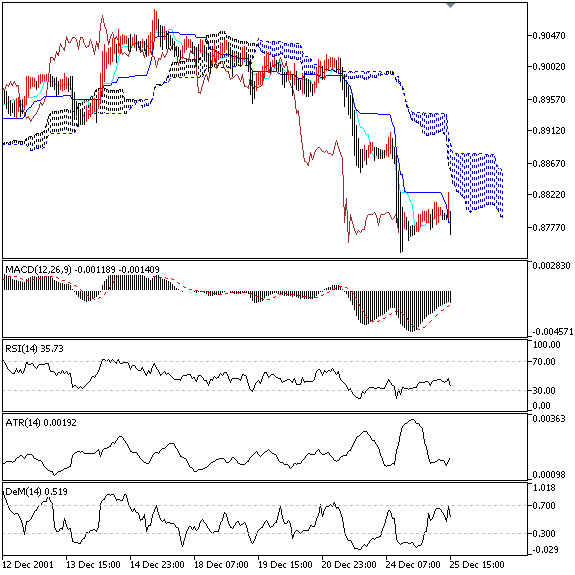

In [11]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### Visualize an image in NumPy array

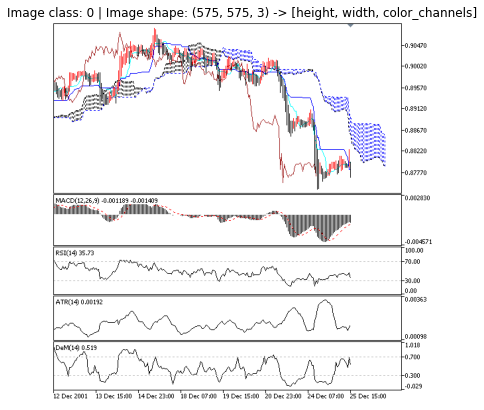

In [12]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Transforming data with torchvision.transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


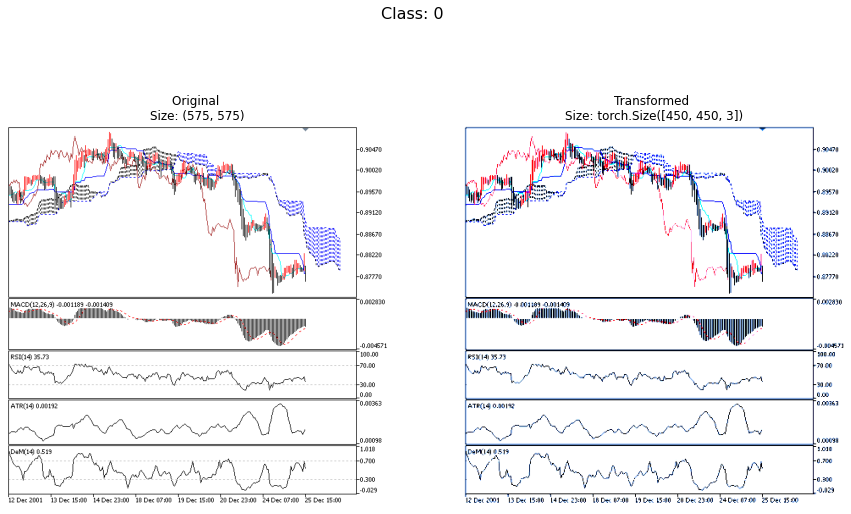

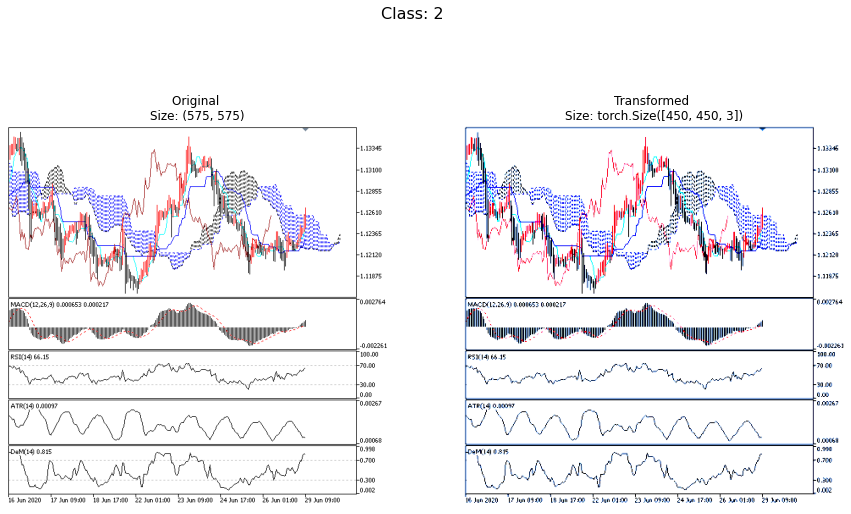

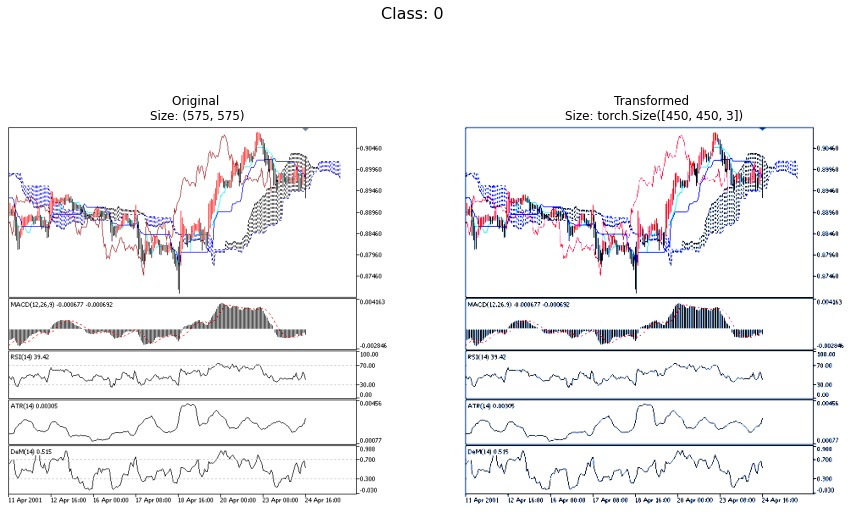

In [19]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2, figsize=(15, 9))
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=manual_transforms, 
                        n=3)

In [17]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((450, 450)), # 1. Reshape all images to 512x512 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

### Loading Image Data Using ImageFolder and print inside variables

In [13]:
# Use ImageFolder to create dataset(s)
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,                                                                               
                                                                               test_dir=val_dir,
                                                                               val_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7febec29e0d0>,
 ['0', '1', '2'])

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
weights

EfficientNet_B3_Weights.IMAGENET1K_V1

In [15]:
model = torchvision.models.efficientnet_b3(weights=weights).to(device)

In [16]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 320, 320), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 320, 320]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 320, 320]    [32, 1536, 10, 10]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 320, 320]    [32, 40, 160, 160]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 320, 320]    [32, 40, 160, 160]   1,080                True
│    │    └─BatchNorm2d (1)                                  [32, 40, 160, 160]   [32, 40, 160, 160]   80                   True
│    │    └─SiLU (2)                                         [32, 40, 160, 160]   [32, 40, 160, 160]   --                   --
│    └─Sequential (1)                                        [32, 40, 160, 160]   [32, 24, 160

In [17]:
for params in list(model.parameters())[0:-5]:
    params.requires_grad = False

In [18]:
# Set the manual seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True), 
    torch.nn.Linear(in_features=1536, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=12,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7716 | train_acc: 0.7280 | test_loss: 0.7539 | test_acc: 0.7272
Epoch: 2 | train_loss: 0.7581 | train_acc: 0.7279 | test_loss: 0.7401 | test_acc: 0.7284
Epoch: 3 | train_loss: 0.7499 | train_acc: 0.7278 | test_loss: 0.7419 | test_acc: 0.7288
Epoch: 4 | train_loss: 0.7453 | train_acc: 0.7275 | test_loss: 0.7276 | test_acc: 0.7288
Epoch: 5 | train_loss: 0.7375 | train_acc: 0.7279 | test_loss: 0.7262 | test_acc: 0.7276
Epoch: 6 | train_loss: 0.7314 | train_acc: 0.7285 | test_loss: 0.7203 | test_acc: 0.7260
Epoch: 7 | train_loss: 0.7280 | train_acc: 0.7281 | test_loss: 0.7127 | test_acc: 0.7303
Epoch: 8 | train_loss: 0.7219 | train_acc: 0.7289 | test_loss: 0.7113 | test_acc: 0.7292
Epoch: 9 | train_loss: 0.7164 | train_acc: 0.7291 | test_loss: 0.7078 | test_acc: 0.7274
Epoch: 10 | train_loss: 0.7126 | train_acc: 0.7297 | test_loss: 0.7057 | test_acc: 0.7295
Epoch: 11 | train_loss: 0.7080 | train_acc: 0.7302 | test_loss: 0.6997 | test_acc: 0.7297
Epoch: 12 | train_l

In [14]:
weights = torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
model_load = torchvision.models.efficientnet_b3(weights=weights).to(device)

for params in list(model_load.parameters())[0:-5]:
    params.requires_grad = False
output_shape = len(class_names)    
model_load.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True), 
    torch.nn.Linear(in_features=1536, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_load.parameters(), lr=0.001)
PATH = "/notebooks/models/model_efficientnet_b3.pth"
checkpoint = torch.load(PATH)
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine_1.train(model=model_load,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [113]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model_load(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [114]:
# Get a random list of image paths from test set
import random
data_path = Path("/notebooks/")
image_path = data_path / "dataset_divided"
# image_test_path = Path('/notebooks/dataset_divided/test/')
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

In [ ]:
# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(570, 570))

In [21]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [22]:
y_pred, y_test = get_predictions(model_load, val_dataloader)

In [23]:
from sklearn.metrics import classification_report

In [24]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      9818
           1       0.47      0.18      0.26      1818
           2       0.51      0.14      0.22      1832

    accuracy                           0.74     13468
   macro avg       0.58      0.42      0.44     13468
weighted avg       0.69      0.74      0.68     13468



In [27]:
import pandas as pd

In [31]:
a = pd.DataFrame(y_pred)
b = pd.DataFrame(y_test)

In [30]:
a.value_counts()

0    12267
1      697
2      504
dtype: int64

In [32]:
b.value_counts()

0    9818
2    1832
1    1818
dtype: int64